# Introduction
This notebook implements a **Graph Convolutional Autoencoder (GCN-AE)** framework for semi-supervised fraud detection in financial transaction networks. The model learns low-dimensional embeddings of nodes while simultaneously reconstructing graph structure and optimizing classification accuracy. The workflow covers data preprocessing, model architecture, training, evaluation, and visualization.

In [1]:
import os
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.datasets import EllipticBitcoinDataset
from torch_geometric.nn import GCNConv
from sklearn.metrics import classification_report

d:\DL Project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = EllipticBitcoinDataset(root='./dataset')
data = dataset[0]
print(data)

Data(x=[203769, 165], edge_index=[2, 234355], y=[203769], train_mask=[203769], test_mask=[203769])


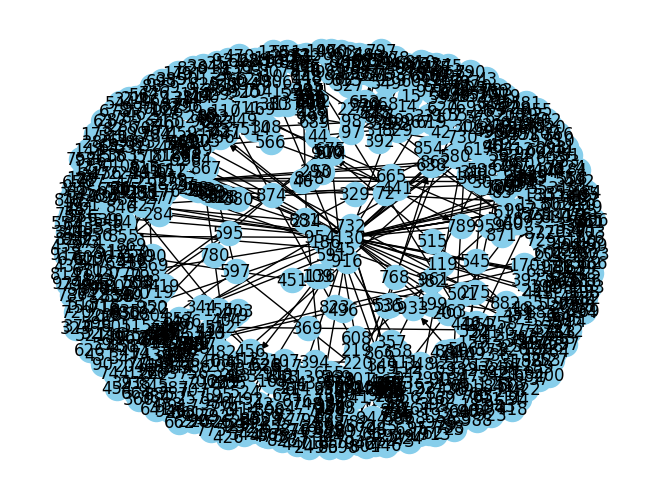

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Convert first 1000 nodes + edges to NetworkX graph
subgraph_nodes = range(1000)
subgraph = data.edge_index[:, (data.edge_index[0] < 1000) & (data.edge_index[1] < 1000)]
G = nx.DiGraph()
G.add_edges_from(subgraph.t().tolist())
nx.draw(G, with_labels=True, node_color='skyblue', node_size=300)
plt.show()

In [5]:
print(data.edge_index.dtype)  # Check the dtype of edge_index
print(data.y.unique())          # Check the dtype of labels

torch.int64
tensor([0, 1, 2])


## Data Loading and Preprocessing
This section loads the transaction dataset, constructs the graph structure, and prepares node features and labels. The PyTorch Geometric (PyG) library is used to represent graph data efficiently.

In [6]:
data.edge_index = data.edge_index.to(torch.long)  
mask = data.y != -1
labels = data.y.clone()

In [7]:
from sklearn.model_selection import train_test_split
mask_idx = mask.nonzero(as_tuple=True)[0]
train_idx, test_idx = train_test_split(mask_idx.cpu(), test_size=0.3, stratify=labels[mask].cpu(), random_state=42)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, stratify=labels[test_idx].cpu(), random_state=42)
train_idx = train_idx.to(DEVICE)
val_idx = val_idx.to(DEVICE)
test_idx = test_idx.to(DEVICE)

In [8]:
class GCNEncoder(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=0.3):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hid_dim)
        self.conv2 = GCNConv(hid_dim, out_dim)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        z = self.conv2(x, edge_index)
        return z

In [9]:
class AEClassifier(nn.Module):
    def __init__(self, encoder, out_dim):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(encoder.conv2.out_channels, out_dim)

    def forward(self, x, edge_index):
        z = self.encoder(x, edge_index)
        out = self.classifier(z)
        # Reconstruction as regularizer
        # Use inner product reconstruction of adjacency (sparse)
        row, col = edge_index
        pos_scores = (z[row] * z[col]).sum(dim=1)
        recon_loss = -torch.log(torch.sigmoid(pos_scores) + 1e-8).mean()
        return out, recon_loss

## Hyperparameter Configuration
Here we define key hyperparameters such as learning rate, hidden dimensions, weight decay, and the reconstruction loss factor. These govern model performance, convergence rate, and regularization strength.

In [10]:
# Hyperparameters
in_dim = data.x.size(1)
hid_dim = 128
out_dim = int(labels[mask].max().item() + 1)
lr = 0.01
weight_decay = 5e-4
epochs = 100
lambda_recon = 0.1

## Model Definition
The **Graph Convolutional Autoencoder (GCN-AE)** consists of an encoder that learns node embeddings using graph convolutional layers and an optional decoder that reconstructs adjacency relationships. This section defines the model architecture, including the encoder, decoder, and reconstruction components.

In [11]:
encoder = GCNEncoder(in_dim, hid_dim, 64).to(DEVICE)
model_base = AEClassifier(encoder, out_dim).to(DEVICE)
optimizer = torch.optim.Adam(model_base.parameters(), lr=lr, weight_decay=weight_decay)

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

def evaluate_model(model, data, test_idx, labels, name, metrics_store):
    model.eval()
    with torch.no_grad():
        logits, _ = model(data.x, data.edge_index)
        preds = logits.argmax(dim=1)[test_idx].cpu()
        y_true = labels[test_idx].cpu()

    precision = precision_score(y_true, preds, average='macro', zero_division=0)
    recall = recall_score(y_true, preds, average='macro', zero_division=0)
    f1 = f1_score(y_true, preds, average='macro', zero_division=0)
    acc = accuracy_score(y_true, preds)
    report = classification_report(y_true, preds, output_dict=True, zero_division=0)

    # Save metrics
    metrics_store[name] = {
        "precision": round(precision, 4),
        "recall": round(recall, 4),
        "f1": round(f1, 4),
        "accuracy": round(acc, 4),
        "per_class_report": report
    }

    print(f"✅ {name} Model Results:")
    print(f"  Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | Accuracy: {acc:.4f}\n")
    print(f"  Per-Class Report:")
    for class_label, metrics in report.items():
        if class_label == "accuracy":
            continue
        print(f"    Class {class_label}: Precision: {metrics['precision']:.4f} | Recall: {metrics['recall']:.4f} | F1: {metrics['f1-score']:.4f}")
    return preds


## Baseline Training on the Original Dataset

The model was initially trained using the unmodified dataset containing all classes in their original proportions.
This setup served as a baseline to observe how class imbalance affected performance, particularly in detecting the minority fraud class.

In [13]:
# Training loop Normal
for epoch in range(1, epochs+1):
    model_base.train()
    optimizer.zero_grad()
    out, recon_loss = model_base(data.x, data.edge_index)
    ce_loss = F.cross_entropy(out[train_idx], labels[train_idx])
    loss = ce_loss + lambda_recon * recon_loss
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0 or epoch==1:
        model_base.eval()
        with torch.no_grad():
            pred = out.argmax(dim=1)
            print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f}")
            print("Validation Metrics:")
            print(classification_report(labels[val_idx].cpu(), pred[val_idx].cpu(), zero_division=0))


Epoch 001 | Loss: 1.1323
Validation Metrics:
              precision    recall  f1-score   support

           0       0.23      0.43      0.30      6303
           1       0.02      0.21      0.03       681
           2       0.82      0.38      0.52     23581

    accuracy                           0.39     30565
   macro avg       0.36      0.34      0.29     30565
weighted avg       0.68      0.39      0.46     30565

Epoch 005 | Loss: 0.6492
Validation Metrics:
              precision    recall  f1-score   support

           0       0.72      0.26      0.39      6303
           1       0.00      0.00      0.00       681
           2       0.81      0.97      0.89     23581

    accuracy                           0.80     30565
   macro avg       0.51      0.41      0.42     30565
weighted avg       0.77      0.80      0.76     30565

Epoch 010 | Loss: 0.5528
Validation Metrics:
              precision    recall  f1-score   support

           0       0.72      0.23      0.35     

In [14]:
# Test evaluation Normal
model_base.eval()
with torch.no_grad():
    out, _ = model_base(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    print("Test Metrics:")
    print(classification_report(data.y[test_idx].cpu(), pred[test_idx].cpu(), zero_division=0))

Test Metrics:
              precision    recall  f1-score   support

           0       0.78      0.54      0.64      6303
           1       0.93      0.04      0.07       682
           2       0.87      0.96      0.91     23581

    accuracy                           0.85     30566
   macro avg       0.86      0.51      0.54     30566
weighted avg       0.85      0.85      0.84     30566



In [15]:
metrics_data = {}

evaluate_model(model_base, data, test_idx, labels, "Base", metrics_data)

✅ Base Model Results:
  Precision: 0.8567 | Recall: 0.5132 | F1: 0.5402 | Accuracy: 0.8535

  Per-Class Report:
    Class 0: Precision: 0.7780 | Recall: 0.5426 | F1: 0.6393
    Class 1: Precision: 0.9259 | Recall: 0.0367 | F1: 0.0705
    Class 2: Precision: 0.8661 | Recall: 0.9602 | F1: 0.9107
    Class macro avg: Precision: 0.8567 | Recall: 0.5132 | F1: 0.5402
    Class weighted avg: Precision: 0.8493 | Recall: 0.8535 | F1: 0.8360


tensor([2, 2, 2,  ..., 2, 2, 2])

## Training with Class Weights

To mitigate class imbalance, class-specific weights were introduced in the loss function.
The weights were inversely proportional to class frequency, ensuring that the model penalized misclassification of minority (fraudulent) samples more heavily. This adjustment aimed to improve sensitivity toward rare but critical fraudulent nodes.

In [16]:
# Weighted Method
import torch
from torch.nn import CrossEntropyLoss

# Only training nodes
train_labels = labels[train_idx]

# Class counts and weights
class_counts = torch.bincount(train_labels)
class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum() * len(class_counts)
print("Class weights:", class_weights)

# Cross-entropy with weights
ce_loss_fn = CrossEntropyLoss(weight=class_weights)


Class weights: tensor([0.2854, 2.6383, 0.0763])


In [17]:
model_weighted = AEClassifier(encoder, out_dim).to(DEVICE)

# Training on weighted Data
for epoch in range(1, epochs+1):
    model_weighted.train()
    optimizer.zero_grad()
    out, recon_loss = model_weighted(data.x, data.edge_index)

    ce_loss = ce_loss_fn(out[train_idx], labels[train_idx])
    loss = ce_loss + lambda_recon * recon_loss
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0 or epoch==1:
        model_weighted.eval()
        with torch.no_grad():
            pred = out.argmax(dim=1)
            print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f}")
            print("Validation Metrics:")
            print(classification_report(labels[val_idx].cpu(), pred[val_idx].cpu(), zero_division=0))


Epoch 001 | Loss: 1.2988
Validation Metrics:
              precision    recall  f1-score   support

           0       0.29      0.00      0.00      6303
           1       0.34      0.12      0.18       681
           2       0.77      1.00      0.87     23581

    accuracy                           0.77     30565
   macro avg       0.47      0.37      0.35     30565
weighted avg       0.67      0.77      0.68     30565

Epoch 020 | Loss: 0.6506
Validation Metrics:
              precision    recall  f1-score   support

           0       0.53      0.73      0.61      6303
           1       0.10      0.81      0.17       681
           2       0.93      0.64      0.75     23581

    accuracy                           0.66     30565
   macro avg       0.52      0.72      0.51     30565
weighted avg       0.83      0.66      0.71     30565

Epoch 040 | Loss: 0.5799
Validation Metrics:
              precision    recall  f1-score   support

           0       0.58      0.72      0.64     

In [18]:
# Test evaluation for only weighted
model_weighted.eval()
with torch.no_grad():
    out, _ = model_weighted(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    print("Test Metrics:")
    print(classification_report(data.y[test_idx].cpu(), pred[test_idx].cpu(), zero_division=0))

Test Metrics:
              precision    recall  f1-score   support

           0       0.61      0.76      0.67      6303
           1       0.17      0.87      0.28       682
           2       0.93      0.76      0.84     23581

    accuracy                           0.76     30566
   macro avg       0.57      0.79      0.60     30566
weighted avg       0.85      0.76      0.79     30566



In [19]:
evaluate_model(model_weighted, data, test_idx, labels, "Weighted", metrics_data)

✅ Weighted Model Results:
  Precision: 0.5693 | Recall: 0.7949 | F1: 0.5976 | Accuracy: 0.7612

  Per-Class Report:
    Class 0: Precision: 0.6052 | Recall: 0.7577 | F1: 0.6729
    Class 1: Precision: 0.1685 | Recall: 0.8680 | F1: 0.2822
    Class 2: Precision: 0.9341 | Recall: 0.7590 | F1: 0.8375
    Class macro avg: Precision: 0.5693 | Recall: 0.7949 | F1: 0.5976
    Class weighted avg: Precision: 0.8492 | Recall: 0.7612 | F1: 0.7912


tensor([2, 2, 1,  ..., 0, 2, 2])

## Training with Class Weights and Oversampling

Beyond weighting, the minority fraud class was oversampled to increase its representation within each training batch. This hybrid strategy (weights + oversampling) further balanced the training signal, allowing the model to better capture patterns associated with fraudulent behavior while maintaining stability.

In [20]:
# Oversampling Class 1 Data

# Separate classes
idx_class0 = train_idx[train_labels == 0]
idx_class1 = train_idx[train_labels == 1]
idx_class2 = train_idx[train_labels == 2]

# Oversample minority (class 1) to match majority class
num_majority = max(len(idx_class0), len(idx_class2))
idx_class1_oversampled = idx_class1.repeat((num_majority // len(idx_class1) + 1))[:num_majority]

# Combine all
train_idx_balanced = torch.cat([idx_class0, idx_class1_oversampled, idx_class2])
train_idx_balanced = train_idx_balanced[torch.randperm(len(train_idx_balanced))]  # shuffle

In [21]:
model_weighted_oversampled = AEClassifier(encoder, out_dim).to(DEVICE)
# Training on weighted + oversampled data

for epoch in range(1, epochs+1):
    model_weighted_oversampled.train()
    optimizer.zero_grad()
    out, recon_loss = model_weighted_oversampled(data.x, data.edge_index)

    # Use oversampled indices
    ce_loss = ce_loss_fn(out[train_idx_balanced], labels[train_idx_balanced])
    loss = ce_loss + lambda_recon * recon_loss
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0 or epoch == 1:
        model_weighted_oversampled.eval()
        with torch.no_grad():
            pred = out.argmax(dim=1)
            print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f}")
            print("Validation Metrics:")
            print(classification_report(labels[val_idx].cpu(), pred[val_idx].cpu(), zero_division=0))


Epoch 001 | Loss: 1.6061
Validation Metrics:
              precision    recall  f1-score   support

           0       0.05      0.00      0.00      6303
           1       0.00      0.02      0.00       681
           2       0.84      0.68      0.75     23581

    accuracy                           0.53     30565
   macro avg       0.30      0.24      0.25     30565
weighted avg       0.66      0.53      0.58     30565

Epoch 005 | Loss: 0.4333
Validation Metrics:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6303
           1       0.02      1.00      0.04       681
           2       0.00      0.00      0.00     23581

    accuracy                           0.02     30565
   macro avg       0.01      0.33      0.01     30565
weighted avg       0.00      0.02      0.00     30565

Epoch 010 | Loss: 0.4044
Validation Metrics:
              precision    recall  f1-score   support

           0       0.69      0.13      0.22     

In [22]:
# Test evaluation using weighted + oversampling
model_weighted_oversampled.eval()
with torch.no_grad():
    out, _ = model_weighted_oversampled(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    print("Test Metrics:")
    print(classification_report(data.y[test_idx].cpu(), pred[test_idx].cpu(), zero_division=0))

Test Metrics:
              precision    recall  f1-score   support

           0       0.59      0.56      0.57      6303
           1       0.04      0.98      0.08       682
           2       0.94      0.33      0.49     23581

    accuracy                           0.39     30566
   macro avg       0.52      0.62      0.38     30566
weighted avg       0.85      0.39      0.50     30566



In [23]:
evaluate_model(model_weighted_oversampled, data, test_idx, labels, "Weighted + Oversampled", metrics_data)

✅ Weighted + Oversampled Model Results:
  Precision: 0.5215 | Recall: 0.6242 | F1: 0.3798 | Accuracy: 0.3915

  Per-Class Report:
    Class 0: Precision: 0.5853 | Recall: 0.5608 | F1: 0.5728
    Class 1: Precision: 0.0412 | Recall: 0.9824 | F1: 0.0791
    Class 2: Precision: 0.9380 | Recall: 0.3292 | F1: 0.4874
    Class macro avg: Precision: 0.5215 | Recall: 0.6242 | F1: 0.3798
    Class weighted avg: Precision: 0.8453 | Recall: 0.3915 | F1: 0.4959


tensor([2, 2, 1,  ..., 1, 1, 1])

## Training on Known Classes (Licit and Illicit Only)

In the final stage, training was restricted to known classes — licit and illicit — excluding any unknown or ambiguous class labels. This controlled setup was used to refine decision boundaries specifically between legitimate and fraudulent entities, improving clarity in anomaly scoring and interpretability.

In [24]:
# Labels and masks
labels = data.y.clone().to(DEVICE)     # [num_nodes]
# known nodes: classes 0 and 1
known_mask = (labels == 0) | (labels == 1)
known_idx = known_mask.nonzero(as_tuple=True)[0]
# unknown nodes: class 2
unknown_idx = (labels == 2).nonzero(as_tuple=True)[0]

In [25]:
train_idx, val_idx = train_test_split(
    known_idx.cpu().numpy(),
    test_size=0.2,
    stratify=labels[known_idx].cpu().numpy(),
    random_state=42
)
train_idx = torch.tensor(train_idx, dtype=torch.long, device=DEVICE)
val_idx = torch.tensor(val_idx, dtype=torch.long, device=DEVICE)
test_unknown_idx = unknown_idx.to(DEVICE)

print(f"Train known: {train_idx.size(0)}, Val known: {val_idx.size(0)}, Unknown test: {test_unknown_idx.size(0)}")

Train known: 37251, Val known: 9313, Unknown test: 157205


In [26]:
# compute class weights from training labels (only known classes)
train_labels = labels[train_idx]
class_counts = torch.bincount(train_labels)
# handle if some class missing in batch (rare)
if class_counts.numel() < 2:
    # ensure 2 classes exist
    tmp = torch.zeros(2, dtype=class_counts.dtype, device=class_counts.device)
    tmp[:class_counts.numel()] = class_counts
    class_counts = tmp
class_weights = 1.0 / class_counts.float()
class_weights = (class_weights / class_weights.sum()) * len(class_counts)
class_weights = class_weights.to(DEVICE)
print("Class counts:", class_counts.cpu().numpy(), "Class weights:", class_weights.cpu().numpy())

ce_loss_fn = nn.CrossEntropyLoss(weight=class_weights)

Class counts: [33615  3636] Class weights: [0.19521624 1.8047837 ]


In [27]:
class AEClassifier(nn.Module):
    def __init__(self, encoder, num_classes):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(encoder.conv2.out_channels, num_classes)

    def forward(self, x, edge_index):
        # Encode graph node embeddings
        z = self.encoder(x, edge_index)

        # Node classification
        out = self.classifier(z)

        # Reconstruction (inner product of embeddings)
        row, col = edge_index
        pos_scores = (z[row] * z[col]).sum(dim=1)
        recon_loss = -torch.log(torch.sigmoid(pos_scores) + 1e-8).mean()

        return out, recon_loss

In [28]:
num_classes = 2

encoder = GCNEncoder(in_dim, hid_dim, 64).to(DEVICE)
model_known_unknown = AEClassifier(encoder, num_classes).to(DEVICE)
optimizer = torch.optim.Adam(model_known_unknown.parameters(), lr=lr, weight_decay=weight_decay)

In [29]:
epochs = 100

for epoch in range(1, epochs + 1):
    model_known_unknown.train()
    optimizer.zero_grad()
    logits, z_all = model_known_unknown(data.x, data.edge_index)           # logits: [N, num_classes]
    # select only train nodes (labels 0 or 1)
    loss_ce = ce_loss_fn(logits[train_idx], labels[train_idx])
    rloss = torch.tensor(0.0, device=DEVICE)
    loss = loss_ce + lambda_recon * rloss
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0 or epoch == 1:
        model_known_unknown.eval()
        with torch.no_grad():
            logits_eval, _ = model_known_unknown(data.x, data.edge_index)
            preds_val = logits_eval[val_idx].argmax(dim=1).cpu()
            true_val = labels[val_idx].cpu()
            print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | CE: {loss_ce.item():.4f} | Recon: {rloss.item():.4f}")
            print("Val known metrics:")
            print(classification_report(true_val, preds_val, target_names=['licit(0)','illicit(1)'], zero_division=0))


Epoch 001 | Loss: 0.7586 | CE: 0.7586 | Recon: 0.0000
Val known metrics:
              precision    recall  f1-score   support

    licit(0)       0.90      1.00      0.95      8404
  illicit(1)       0.78      0.02      0.03       909

    accuracy                           0.90      9313
   macro avg       0.84      0.51      0.49      9313
weighted avg       0.89      0.90      0.86      9313

Epoch 005 | Loss: 0.5253 | CE: 0.5253 | Recon: 0.0000
Val known metrics:
              precision    recall  f1-score   support

    licit(0)       0.99      0.59      0.74      8404
  illicit(1)       0.20      0.95      0.34       909

    accuracy                           0.63      9313
   macro avg       0.60      0.77      0.54      9313
weighted avg       0.91      0.63      0.70      9313

Epoch 010 | Loss: 0.4480 | CE: 0.4480 | Recon: 0.0000
Val known metrics:
              precision    recall  f1-score   support

    licit(0)       0.98      0.81      0.89      8404
  illicit(1)      

In [30]:
evaluate_model(model_known_unknown, data, train_idx, labels, "Known-Unknown", metrics_data)

✅ Known-Unknown Model Results:
  Precision: 0.7900 | Recall: 0.9449 | F1: 0.8435 | Accuracy: 0.9295

  Per-Class Report:
    Class 0: Precision: 0.9958 | Recall: 0.9258 | F1: 0.9595
    Class 1: Precision: 0.5843 | Recall: 0.9640 | F1: 0.7276
    Class macro avg: Precision: 0.7900 | Recall: 0.9449 | F1: 0.8435
    Class weighted avg: Precision: 0.9556 | Recall: 0.9295 | F1: 0.9369


tensor([0, 0, 0,  ..., 0, 0, 0])

In [31]:
model_known_unknown.eval()
with torch.no_grad():
    logits_all, _ = model_known_unknown(data.x, data.edge_index)
    probs = F.softmax(logits_all, dim=1)  # probabilities for classes 0 and 1
    # For unknown nodes, get probability of illicit (class 1)
    illicit_probs_unknown = probs[test_unknown_idx, 1].cpu()
    # rank unknowns
    topk = 100
    if illicit_probs_unknown.numel() > topk:
        topk_vals, topk_idx_local = torch.topk(illicit_probs_unknown, topk)
    else:
        topk_vals = illicit_probs_unknown
        topk_idx_local = torch.arange(illicit_probs_unknown.size(0))
    topk_node_indices = test_unknown_idx[topk_idx_local]
    print(f"Top-{topk} suspicious unknown nodes (example indices): {topk_node_indices[:20].cpu().numpy()}")


Top-100 suspicious unknown nodes (example indices): [114916  87179  46452  58112  64509 126460 167102  36509 136455 126197
 127255  71025  94660  37044  58142  75237  71550 116693  66734  64794]


## Graph Visualization
Visualization helps interpret model performance by representing nodes and their predicted or true labels in graph form. Fraudulent nodes are visually distinguished to aid qualitative understanding of the model's predictions.

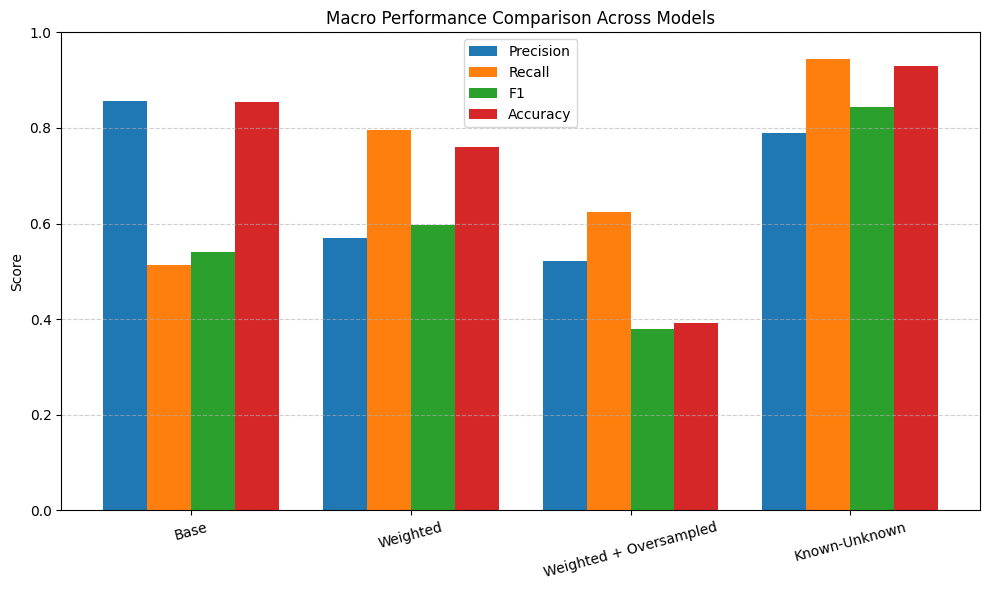

In [32]:
import matplotlib.pyplot as plt
import numpy as np

macro_metrics = ["precision", "recall", "f1", "accuracy"]
models = list(metrics_data.keys())

# Create grouped bar plot
x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(10,6))

for i, metric in enumerate(macro_metrics):
    values = [metrics_data[m][metric] for m in models]
    plt.bar(x + i*width - width*1.5, values, width, label=metric.capitalize())

plt.xticks(x, models, rotation=15)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Macro Performance Comparison Across Models")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

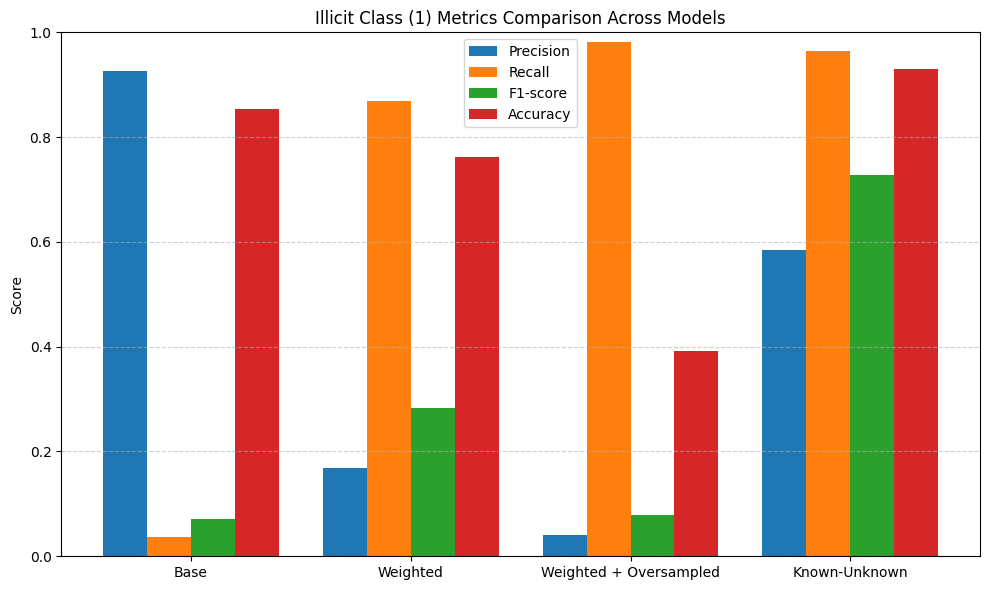

In [33]:
models = list(metrics_data.keys())
metrics_to_plot = ["precision", "recall", "f1-score", "accuracy"]

# Collect values for class 1 + overall accuracy
values_dict = {metric: [] for metric in metrics_to_plot}

for model in models:
    report = metrics_data[model]["per_class_report"]
    # Class 1 metrics
    for metric in ["precision", "recall", "f1-score"]:
        values_dict[metric].append(report.get("1", {}).get(metric, 0.0))
    # Overall accuracy
    values_dict["accuracy"].append(metrics_data[model].get("accuracy", 0.0))

# Plotting
x = np.arange(len(models))
bar_width = 0.2
plt.figure(figsize=(10,6))

for i, metric in enumerate(metrics_to_plot):
    plt.bar(x + i*bar_width - bar_width*1.5, values_dict[metric], width=bar_width, label=metric.capitalize())

plt.xticks(x, models)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Illicit Class (1) Metrics Comparison Across Models")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

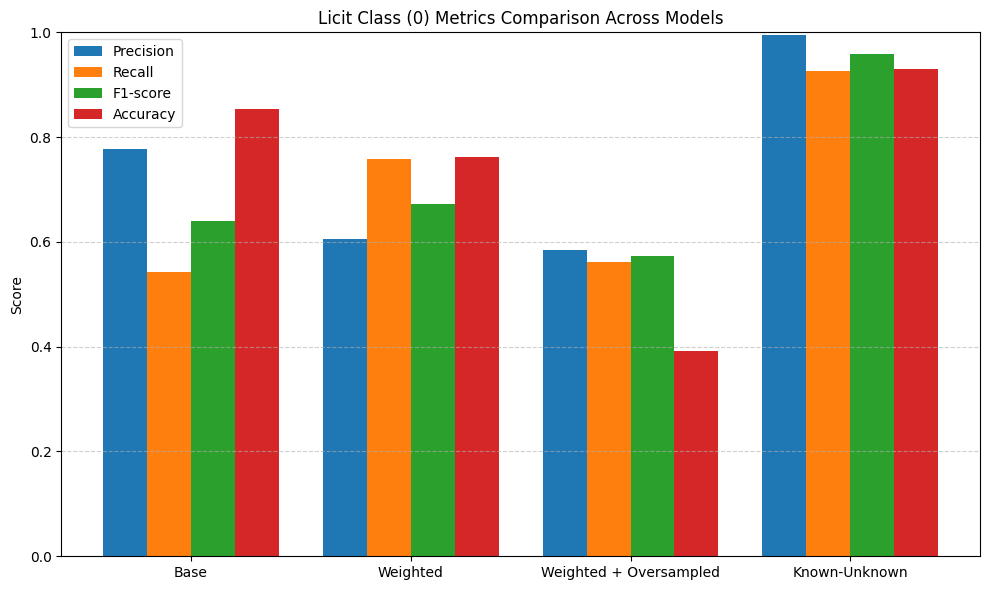

In [34]:
models = list(metrics_data.keys())
metrics_to_plot = ["precision", "recall", "f1-score", "accuracy"]

# Collect values for class 1 + overall accuracy
values_dict = {metric: [] for metric in metrics_to_plot}

for model in models:
    report = metrics_data[model]["per_class_report"]
    # Class 1 metrics
    for metric in ["precision", "recall", "f1-score"]:
        values_dict[metric].append(report.get("0", {}).get(metric, 0.0))
    # Overall accuracy
    values_dict["accuracy"].append(metrics_data[model].get("accuracy", 0.0))

# Plotting
x = np.arange(len(models))
bar_width = 0.2
plt.figure(figsize=(10,6))

for i, metric in enumerate(metrics_to_plot):
    plt.bar(x + i*bar_width - bar_width*1.5, values_dict[metric], width=bar_width, label=metric.capitalize())

plt.xticks(x, models)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Licit Class (0) Metrics Comparison Across Models")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Hyperparameter Tuning and Performance Logging
This section performs a structured exploration of key hyperparameters such as learning rate, weight decay, dropout, and reconstruction weight. The results are stored for comparison, focusing on overall accuracy and precision of the illicit class.

In [ ]:
import itertools

lr_list = [0.001, 0.005, 0.01]
weight_decay_list = [5e-4, 1e-3, 1e-2]
dropout_list = [0.2, 0.3, 0.5]

epochs = 50

results = []

# Loop through all combinations
for lr, wd, dropout in itertools.product(lr_list, weight_decay_list, dropout_list):
    print(f"\n🚀 Training with lr={lr}, weight_decay={wd}, dropout={dropout}")

    num_classes = 2

    encoder = GCNEncoder(in_dim, hid_dim, 64).to(DEVICE)
    model_known_unknown = AEClassifier(encoder, num_classes).to(DEVICE)
    optimizer = torch.optim.Adam(model_known_unknown.parameters(), lr=lr, weight_decay=wd)

    # Training loop
    for epoch in range(epochs):
        model_known_unknown.train()
        optimizer.zero_grad()
        logits, z_all = model_known_unknown(data.x, data.edge_index)           # logits: [N, num_classes]
        # select only train nodes (labels 0 or 1)
        loss_ce = ce_loss_fn(logits[train_idx], labels[train_idx])
        rloss = torch.tensor(0.0, device=DEVICE)
        loss = loss_ce + lambda_recon * rloss
        loss.backward()
        optimizer.step()

    # --- Evaluation ---
    model_known_unknown.eval()
    with torch.no_grad():
        logits, _ = model_known_unknown(data.x, data.edge_index)
        y_pred = logits.argmax(dim=1).cpu()
        y_true = data.y.cpu()

    acc = accuracy_score(y_true[val_idx], y_pred[val_idx])
    results.append({
        "lr": lr,
        "weight_decay": wd,
        "dropout": dropout,
        "accuracy": acc,
    })


🚀 Training with lr=0.001, weight_decay=0.0005, dropout=0.2

🚀 Training with lr=0.001, weight_decay=0.0005, dropout=0.3

🚀 Training with lr=0.001, weight_decay=0.0005, dropout=0.5

🚀 Training with lr=0.001, weight_decay=0.001, dropout=0.2

🚀 Training with lr=0.001, weight_decay=0.001, dropout=0.3

🚀 Training with lr=0.001, weight_decay=0.001, dropout=0.5

🚀 Training with lr=0.001, weight_decay=0.01, dropout=0.2

🚀 Training with lr=0.001, weight_decay=0.01, dropout=0.3

🚀 Training with lr=0.001, weight_decay=0.01, dropout=0.5

🚀 Training with lr=0.005, weight_decay=0.0005, dropout=0.2

🚀 Training with lr=0.005, weight_decay=0.0005, dropout=0.3

🚀 Training with lr=0.005, weight_decay=0.0005, dropout=0.5

🚀 Training with lr=0.005, weight_decay=0.001, dropout=0.2

🚀 Training with lr=0.005, weight_decay=0.001, dropout=0.3

🚀 Training with lr=0.005, weight_decay=0.001, dropout=0.5

🚀 Training with lr=0.005, weight_decay=0.01, dropout=0.2

🚀 Training with lr=0.005, weight_decay=0.01, dropout=

KeyError: 'precision_illicit'

In [36]:
# Convert results to a table for easy viewing
import pandas as pd
results_df = pd.DataFrame(results)
print("\n✅ Hyperparameter Sweep Results:")
print(results_df.sort_values(by="accuracy", ascending=False).to_string(index=False))


✅ Hyperparameter Sweep Results:
   lr  weight_decay  dropout  accuracy
0.010        0.0005      0.3  0.904542
0.010        0.0005      0.5  0.904220
0.010        0.0005      0.2  0.903790
0.005        0.0010      0.3  0.902609
0.005        0.0010      0.5  0.897777
0.010        0.0010      0.2  0.896704
0.005        0.0100      0.2  0.896274
0.005        0.0010      0.2  0.895093
0.005        0.0005      0.2  0.894126
0.005        0.0005      0.5  0.892731
0.010        0.0100      0.3  0.890368
0.005        0.0005      0.3  0.890261
0.010        0.0010      0.5  0.889295
0.010        0.0010      0.3  0.885751
0.010        0.0100      0.5  0.878772
0.010        0.0100      0.2  0.875013
0.005        0.0100      0.5  0.874047
0.005        0.0100      0.3  0.867712
0.001        0.0010      0.5  0.860195
0.001        0.0005      0.2  0.856867
0.001        0.0005      0.3  0.849565
0.001        0.0005      0.5  0.836465
0.001        0.0010      0.3  0.831741
0.001        0.0100      0.5  0